##Scalling up with Tenserflow in Transfer Learning


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi


Sat Jul 24 05:25:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating Helper Functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-24 05:25:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-24 05:25:19 (112 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [4]:
#import series of helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir 

##101 food classes :working with less data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"

--2021-07-24 05:25:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.3’

101_food_classes_10 100%[===================>]   1.51G   137MB/s    in 9.5s    

2021-07-24 05:25:33 (162 MB/s) - ‘101_food_classes_10_percent.zip.3’ saved [1625420029/1625420029]



In [6]:
#chech the image classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10

In [7]:
#setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              
                                                              #dont shuffele the test data in order
                                                              shuffle=False)                                                                          

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train a Model with Transfer Learning with 101 classes

steps to follow:

1.create a model checkpoint callback

2.create a data augmenataion layer to augmenataion right into model

3.build headless functional efficientNet back-boned model

4.compile the model

5.feature extract for 5 full passes and validate on 15% data 

##Model Checkpoint Creation

In [8]:
#craete a model check point
checkpoint_path ="101_classes_10_percent_data_model_checkpoint"

checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        monitor="val_accuracy")

##Create data augmentaion layer

In [9]:
#incorate with the model data
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#setup data augmentaion
data_augmentation=Sequential([
                              preprocessing.RandomFlip("horizontal"),
                              preprocessing.RandomRotation(0.2),
                              preprocessing.RandomHeight(0.2),
                              preprocessing.RandomHeight(0.2),
                              preprocessing.RandomWidth(0.2),
                              preprocessing.RandomZoom(0.2),

                              #this should use for resnet models ,efficient net model has inbuilt rescaling
                              # preprocessing.Rescaling(1/255.),

],name="data_augmenation")

In [10]:
#setup the base model and freeze the layers
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#setup the model with trainable top layer
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),
                    activation="softmax",
                    name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)


In [11]:
#get a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmenation (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


##Compile and Fit the Model


In [12]:
#compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#fit 
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 123s 407ms/step - loss: 3.4908 - accuracy: 0.2417 - val_loss: 2.7780 - val_accuracy: 0.3443
Epoch 2/5
237/237 [==============================] - 80s 337ms/step - loss: 2.3869 - accuracy: 0.4531 - val_loss: 2.2722 - val_accuracy: 0.4420
Epoch 3/5
237/237 [==============================] - 75s 314ms/step - loss: 2.0139 - accuracy: 0.5225 - val_loss: 2.0946 - val_accuracy: 0.4674
Epoch 4/5
237/237 [==============================] - 70s 292ms/step - loss: 1.7983 - accuracy: 0.5682 - val_loss: 2.0173 - val_accuracy: 0.4820
Epoch 5/5
237/237 [==============================] - 69s 289ms/step - loss: 1.6424 - accuracy: 0.5967 - val_loss: 1.9446 - val_accuracy: 0.4894


In [13]:
#evaluate the model
feature_exraction_results=model.evaluate(test_data)
feature_exraction_results

790/790 [==============================] - 89s 113ms/step - loss: 1.7419 - accuracy: 0.5445


[1.7418503761291504, 0.544475257396698]

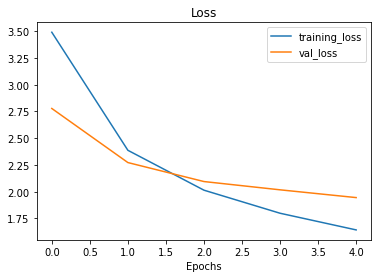

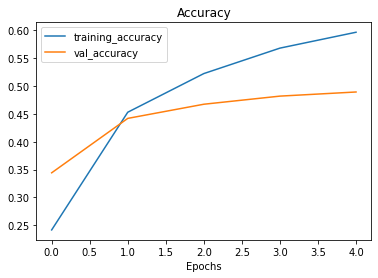

In [14]:
plot_loss_curves(history_all_classes_10_percent)

##Fine Tuning

In [15]:
#unfreeze all of the layers on base model
base_model.trainable =True

#refreeze every layer except last five layers
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [16]:
#recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])


In [17]:
#trainbel layers
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmenation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
#check layers trainble in base model

for layer_number ,layer in enumerate(model.layers[2].layers):

  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

##Fine tune for more 5 epochs

In [19]:
#incease epochs
fine_tune_epochs=10


#fine tune model
history_all_classes_10_percent_fine_tune =model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15*len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1])



Epoch 5/10
237/237 [==============================] - 72s 281ms/step - loss: 1.3989 - accuracy: 0.6412 - val_loss: 1.9188 - val_accuracy: 0.5003
Epoch 6/10
237/237 [==============================] - 64s 270ms/step - loss: 1.2826 - accuracy: 0.6611 - val_loss: 1.9321 - val_accuracy: 0.5042
Epoch 7/10
237/237 [==============================] - 61s 256ms/step - loss: 1.2039 - accuracy: 0.6805 - val_loss: 1.8745 - val_accuracy: 0.5132
Epoch 8/10
237/237 [==============================] - 61s 256ms/step - loss: 1.1252 - accuracy: 0.7015 - val_loss: 1.9423 - val_accuracy: 0.5000
Epoch 9/10
237/237 [==============================] - 59s 246ms/step - loss: 1.0621 - accuracy: 0.7201 - val_loss: 1.9289 - val_accuracy: 0.5029
Epoch 10/10
237/237 [==============================] - 59s 249ms/step - loss: 0.9976 - accuracy: 0.7336 - val_loss: 1.8778 - val_accuracy: 0.5130


In [20]:
#evaluate the model
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)

790/790 [==============================] - 89s 113ms/step - loss: 1.6434 - accuracy: 0.5706


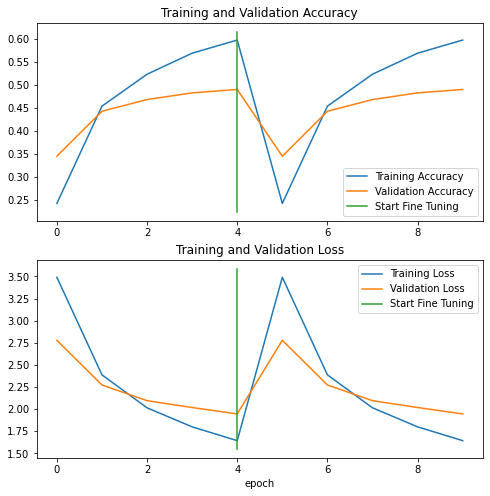

In [21]:
#comapre the histories with fine tune model
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent,
                  initial_epochs=5)

##Save and Load the Model

In [22]:
#save the model
model.save("/content/drive/MyDrive/Dog Vision/models/101 food classification model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dog Vision/models/101 food classification model/assets


In [23]:
#load and evalute the model
loaded_model=tf.keras.models.load_model("/content/drive/MyDrive/Dog Vision/models/101 food classification model")

In [24]:
#evaluate the loaded model
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 91s 114ms/step - loss: 1.6434 - accuracy: 0.5706


[1.643409013748169, 0.5705742835998535]

In [25]:
all_classes_10_percent_fine_tune_results

[1.643409013748169, 0.5705742835998535]

##Evaluating Performance across all different classes

In [26]:
import tensorflow as tf

#download the pretraind model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-07-24 05:49:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.3’

06_101_food_class_1 100%[===================>]  44.59M   153MB/s    in 0.3s    

2021-07-24 05:49:14 (153 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.3’ saved [46760742/46760742]



In [27]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [28]:
#load the save model
model =tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
#evaluate the loaded model
results_downloaded_model =model.evaluate(test_data)

790/790 [==============================] - 95s 118ms/step - loss: 1.8027 - accuracy: 0.6078


##Make Predictions with Trained Model

In [30]:
#oredctions 
preds_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 66s 82ms/step


In [31]:
len(test_data),790*32

(790, 25280)

In [32]:
#count the prediction
len(preds_probs)

25250

In [33]:
25250*101

2550250

In [34]:
preds_probs.shape

(25250, 101)

In [35]:
#check for the first 10 predictions
preds_probs[:10]

array([[5.95420077e-02, 3.57419503e-06, 4.13768589e-02, ...,
        1.41386813e-09, 8.35307583e-05, 3.08974274e-03],
       [9.64016676e-01, 1.37532707e-09, 8.47805641e-04, ...,
        5.42872003e-05, 7.83623513e-12, 9.84663906e-10],
       [9.59258676e-01, 3.25335823e-05, 1.48669467e-03, ...,
        7.18913384e-07, 5.43973158e-07, 4.02759651e-05],
       ...,
       [4.73132670e-01, 1.29312355e-07, 1.48055656e-03, ...,
        5.97501639e-04, 6.69690999e-05, 2.34693434e-05],
       [4.45719399e-02, 4.72655188e-07, 1.22585356e-01, ...,
        6.34984963e-06, 7.53185031e-06, 3.67787597e-03],
       [7.24390090e-01, 1.92497107e-09, 5.23109738e-05, ...,
        1.22913450e-03, 1.57926350e-09, 9.63957209e-05]], dtype=float32)

In [36]:
preds_probs[0],sum(preds_probs[0])

(array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
        8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
        1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
        2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
        6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
        1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
        8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
        2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
        1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
        1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
        8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
        2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
        3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
        8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
        3.5306231e-05, 3.2489133e-05, 6.7314817e

In [37]:
#get the nuber of probalities
print(f"Number of prediction probabilities for sample 0 :{len(preds_probs[0])}")
print(f"what prediction probabilities look like  for sample 0 :{(preds_probs[0])}")
print(f"The class with highest probabilitiy for model sample 0 :{preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0 :101
what prediction probabilities look like  for sample 0 :[5.9542008e-02 3.5741950e-06 4.1376859e-02 1.0660556e-09 8.1613978e-09
 8.6639664e-09 8.0926822e-07 8.5652499e-07 1.9859017e-05 8.0977776e-07
 3.1727747e-09 9.8673661e-07 2.8532164e-04 7.8049051e-10 7.4230169e-04
 3.8916416e-05 6.4740193e-06 2.4977280e-06 3.7891099e-05 2.0678388e-07
 1.5538422e-05 8.1506943e-07 2.6230446e-06 2.0010630e-07 8.3827456e-07
 5.4215989e-06 3.7390860e-06 1.3150533e-08 2.7761406e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688865e-04 7.6407297e-10 4.0452729e-04
 1.3150634e-08 1.7957379e-06 1.4448218e-06 2.3062859e-02 8.2466784e-07
 8.5365781e-07 1.7138614e-06 7.0525107e-06 1.8402169e-08 2.8553407e-07
 7.9483234e-06 2.0681514e-06 1.8525066e-07 3.3619774e-08 3.1522498e-04
 1.0410913e-05 8.5448539e-07 8.4741873e-01 1.0555415e-05 4.4094671e-07
 3.7404148e-05 3.5306231e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219660e-10 1.0318080e-05 8.5744046e-

In [38]:
test_data.class_names[52]

'gyoza'

In [39]:
#get the pred classes for each label
pred_classes=preds_probs.argmax(axis=1)

pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [40]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [41]:
y_labels=[]
for images ,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

##Evaluatng the model Prections

In [42]:
#try accuracy score fucntion
from sklearn.metrics import accuracy_score
sklearn_accuracy =accuracy_score(y_true=y_labels,
                                 y_pred=pred_classes)

sklearn_accuracy


0.6077623762376237

##Make Confution Matrix

In [43]:
from helper_functions import make_confusion_matrix

In [44]:
#get the list of class names
class_names =test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

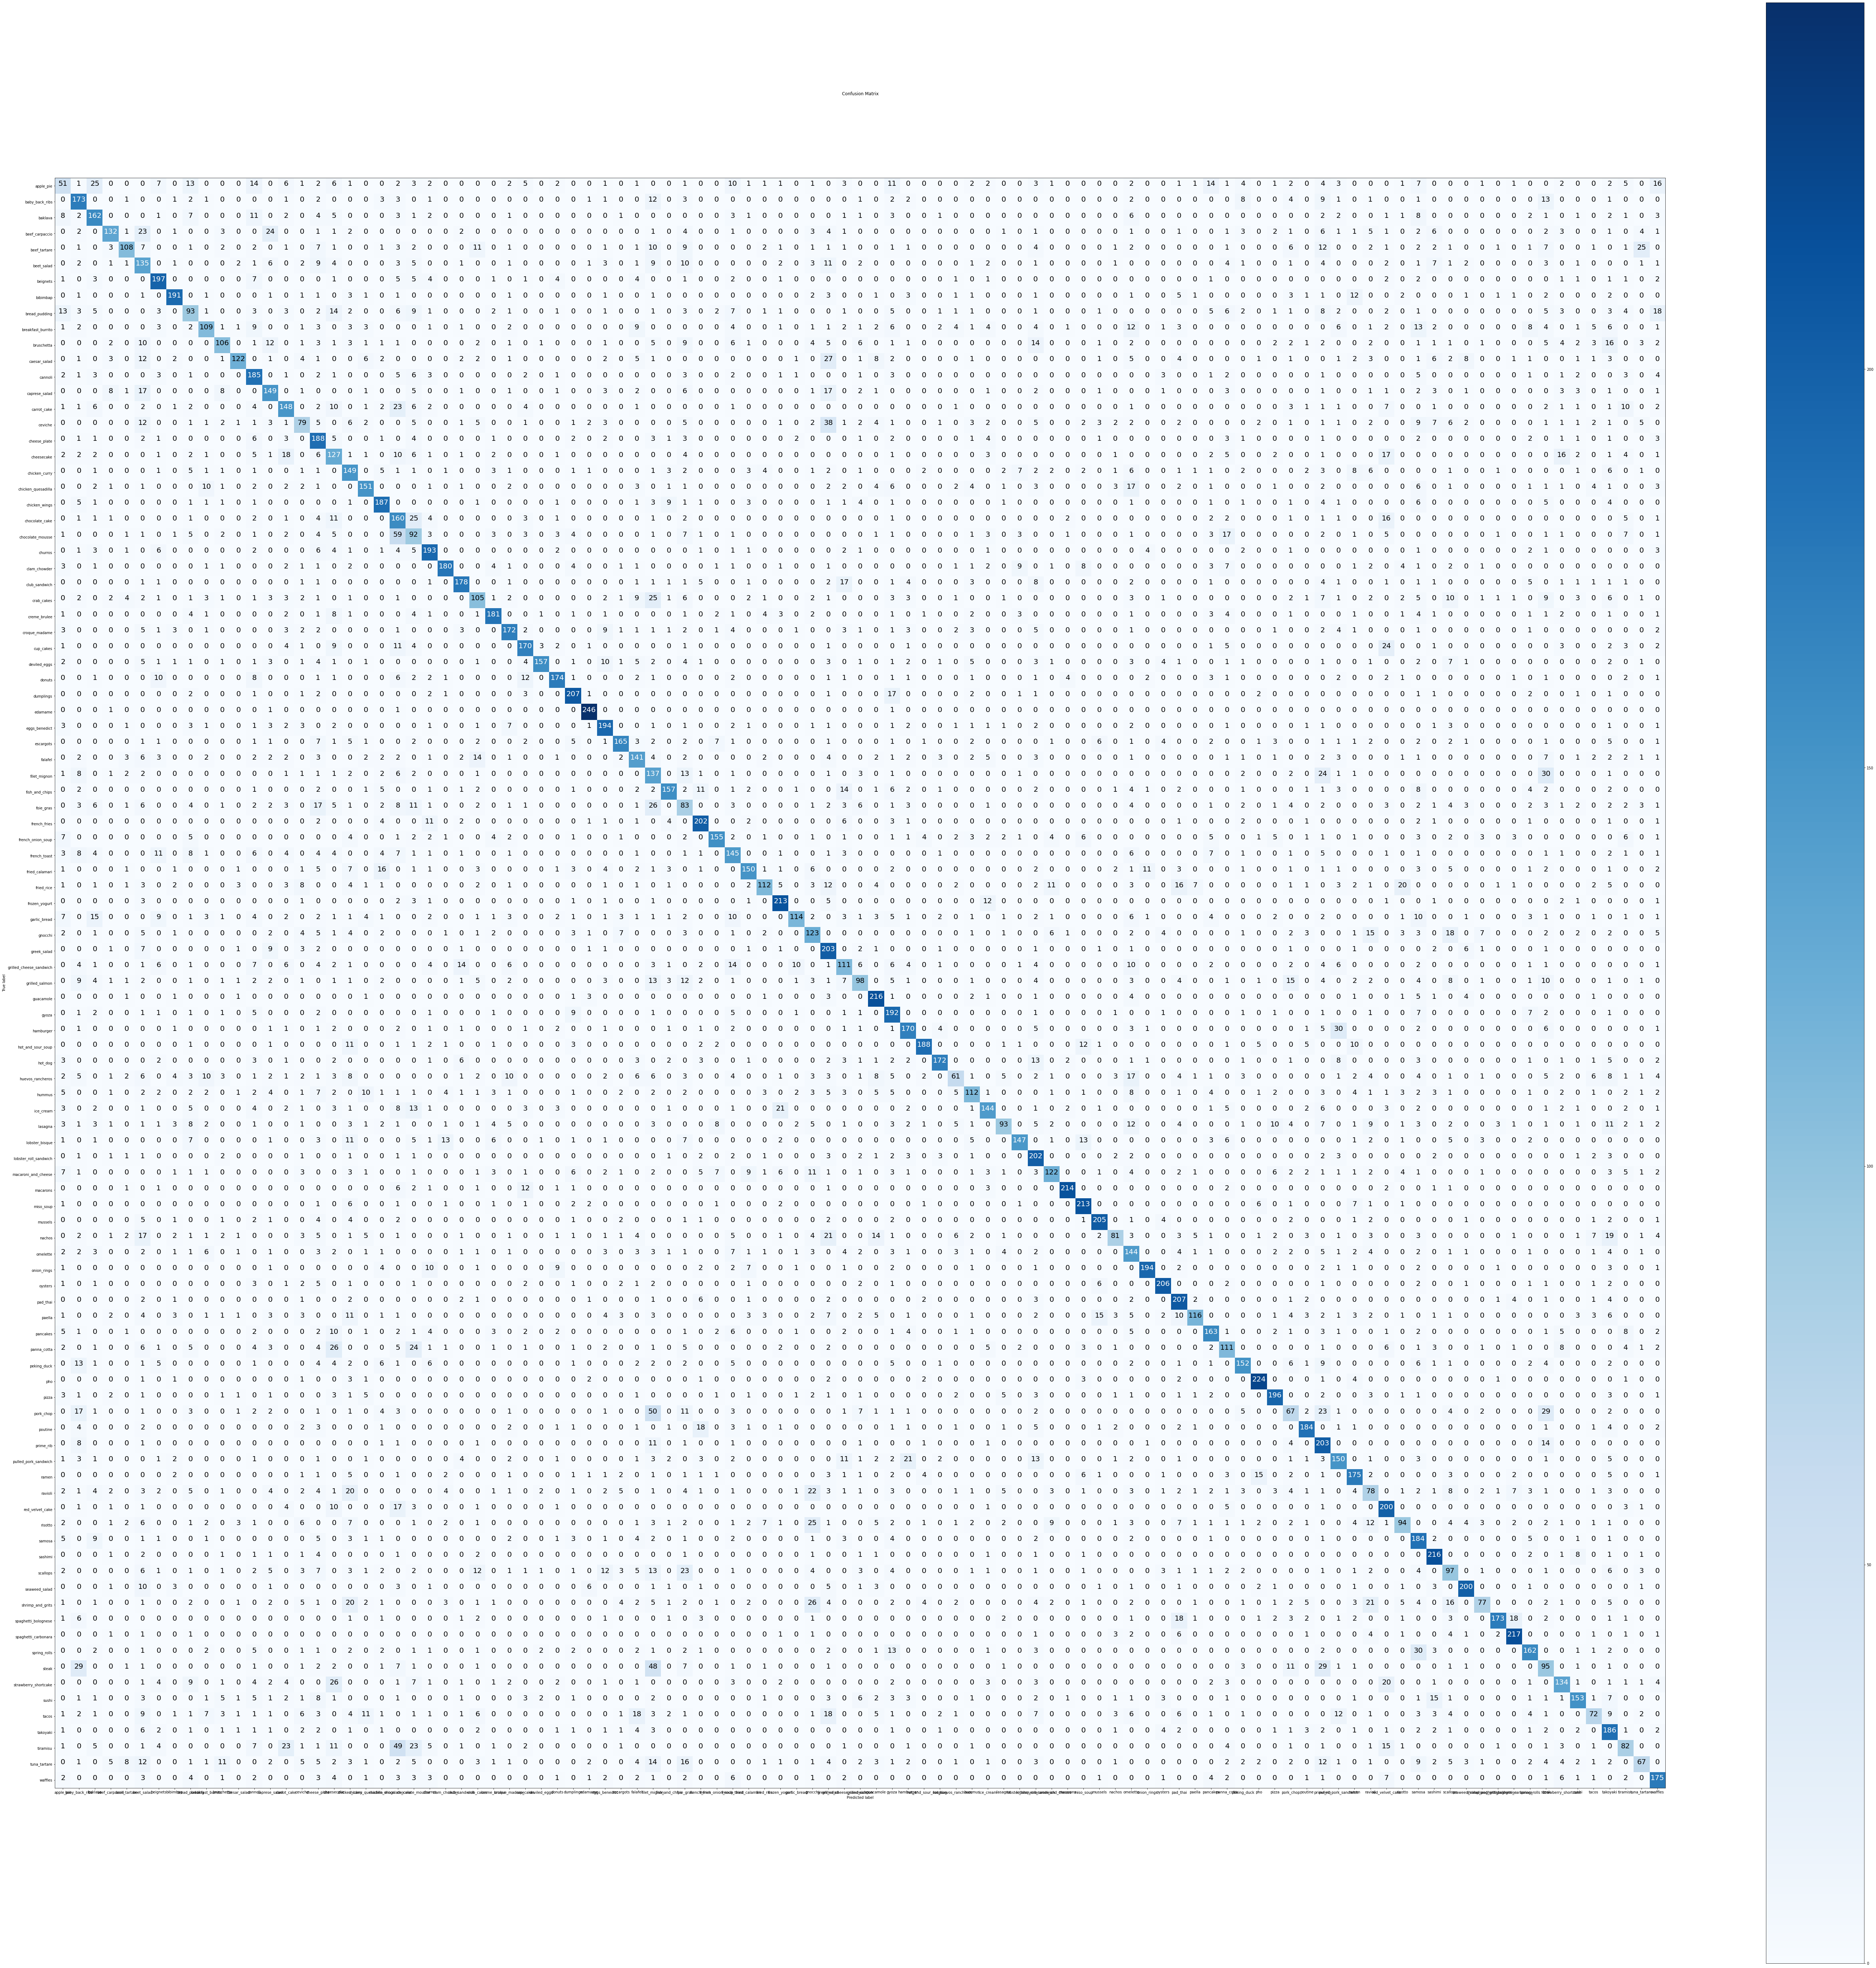

In [45]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [46]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#change the confution matrix functions
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #change plot x label vertical
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

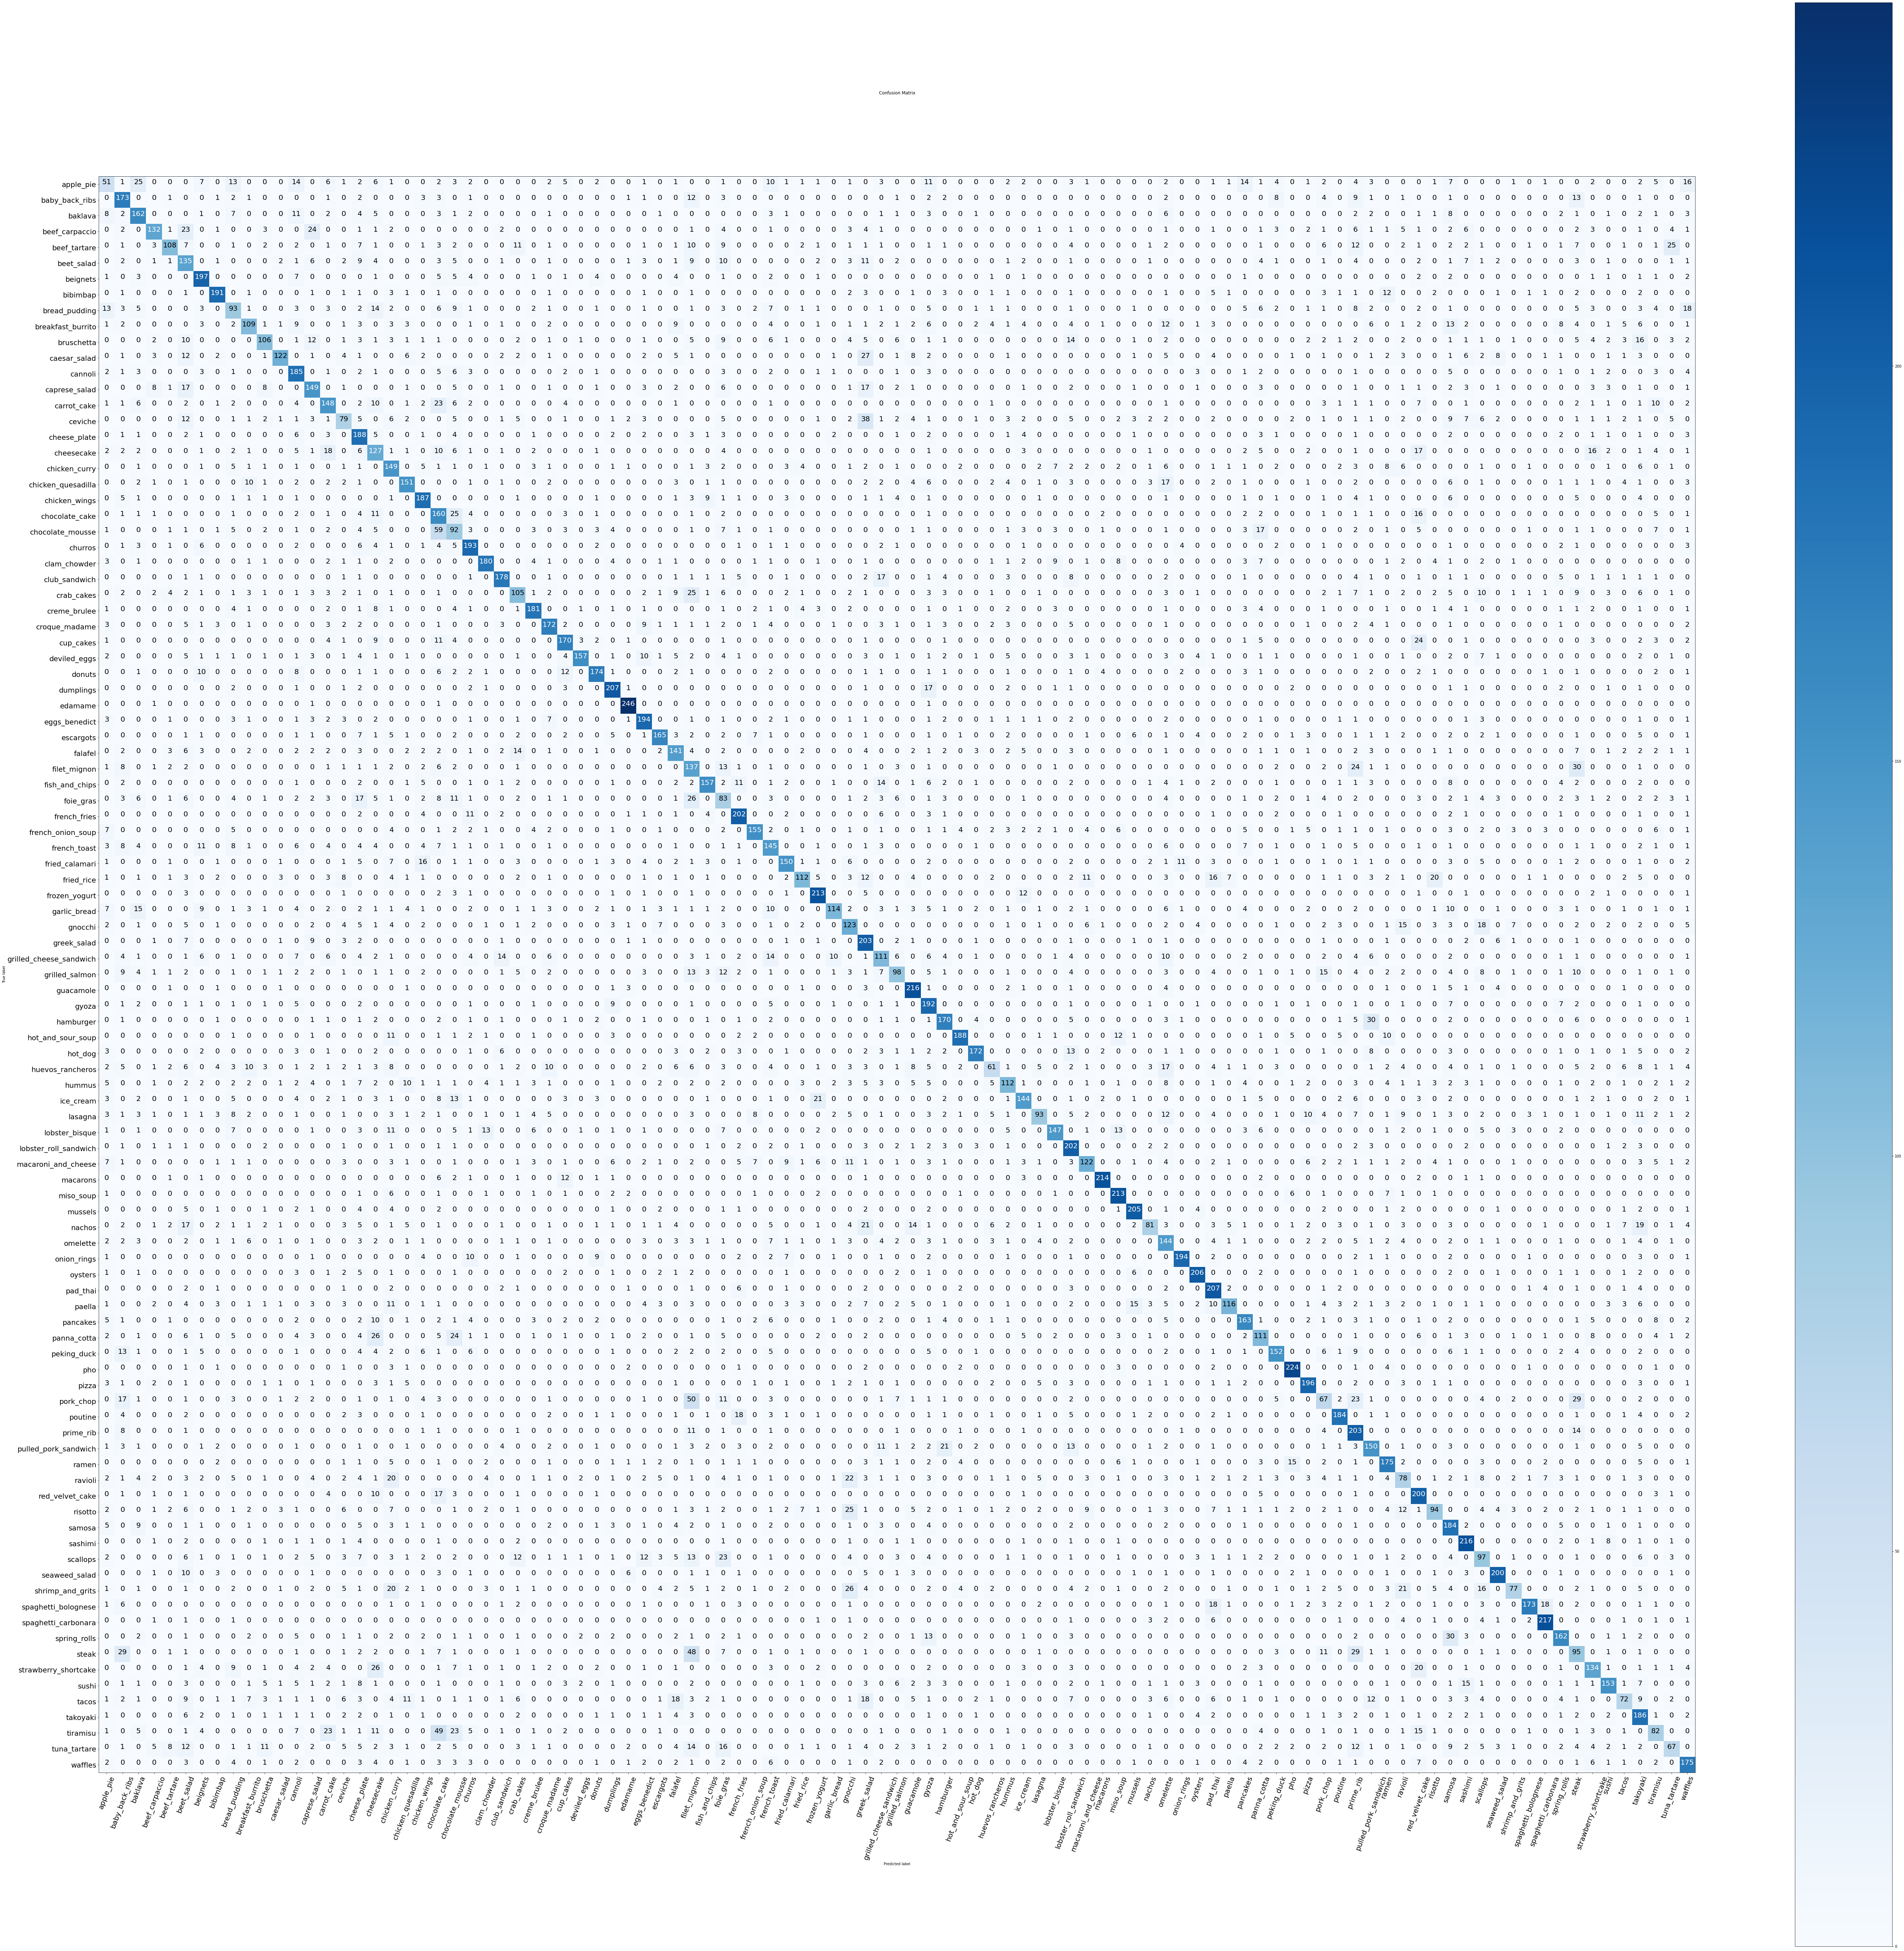

In [47]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

##Create classification report


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [49]:
#get the dictonary of classification report
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [50]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [51]:
#create empty dictonary 
class_f1_scores={}

#loop thourgh classfication report items
for k,v in classification_report_dict.items():
  #stop once come to the accuracy
  if k =="accuracy":
    break

  else:
    #all classnames and f1 scores to new dictonary
    class_f1_scores[class_names[int(k)]] =v["f1-score"]

class_f1_scores


{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [52]:
#turn f1 scores into dataframe
import pandas as pd
f1_scores=pd.DataFrame({"class_names" :list(class_f1_scores.keys()),
                        "f1-score" :list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [53]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

In [54]:
f1_scores[:-10]


class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
5            beet_salad  0.418605
87             scallops  0.397541
37         filet_mignon  0.387006
8         bread_pudding  0.386694
98             tiramisu  0.385882

[91 rows x 2 columns]

##Plot the Bar Chart

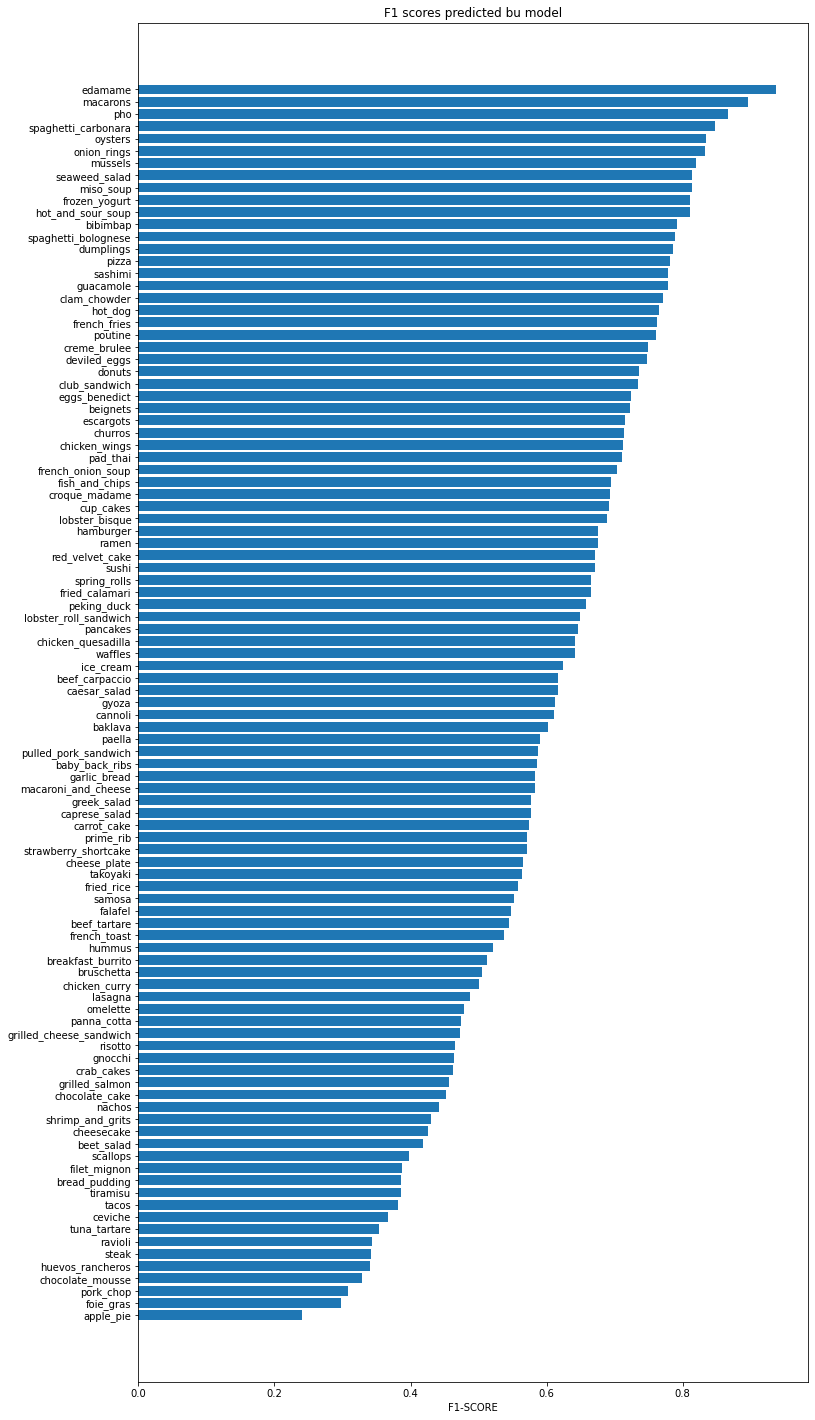

In [55]:
import matplotlib.pyplot as plt

fig,ax =plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)),
               f1_scores["f1-score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-SCORE")

ax.set_title("F1 scores predicted bu model")
ax.invert_yaxis();

# for i in range(len(f1_scores)):
#     plt.annotate(str(class_names[i]), xy=(len(f1_scores)[i],class_naames[i]), ha='center', va='bottom')

# plt.show()


In [56]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

##Visualize Food Images on Real Data

visulaze a image on the model , we need to create function to load and pre process images :

1.Read in a a traget file path 

2.turn image into tensor

3.resize image tensor to same as images trained on

4.scale the image to get all pixel values between 0 & 1


In [57]:
#create a funtion to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  read in an image from filename, turns it into tensor and reshapes into specifed shape

  Args:

  filename(str) :path to target image
  image_shape(int) :height/width dimention of target image size 
  scale(bool) :scale pixrl values from 0-255 to 0-1

  returns:
  image tensor of shape (img_shape,img_shape,3)
  """ 

  #read in the image
  img =tf.io.read_file(filename)

  #decode image into tensor
  img=tf.io.decode_image(img,channels=3)

  #resize the image
  img =tf.image.resize(img,[img_shape,img_shape])

  #scale 
  if scale:
    #rescale the image between 0 and 1
    return img/255.

  else:
    return img
    



##Test the Function

1.load few random images

2.make prdrictions on loaded images

3.plot original images 

101_food_classes_10_percent/test/nachos/3293771.jpg
101_food_classes_10_percent/test/creme_brulee/779678.jpg
101_food_classes_10_percent/test/cheesecake/1765499.jpg


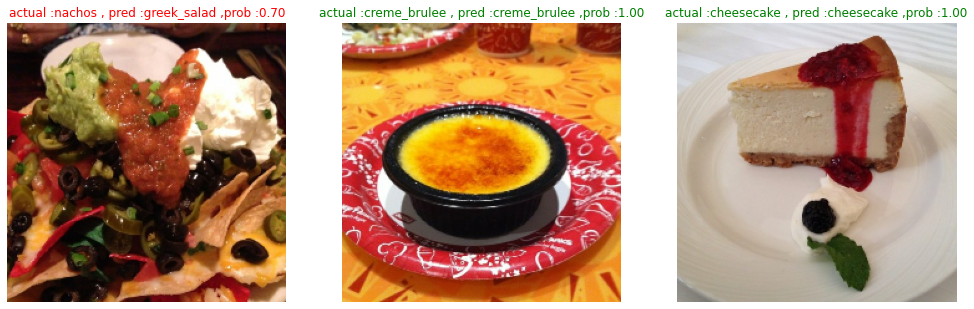

In [58]:
#make predctions
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  #choose random image from a random image
  class_name =random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+"/"+class_name))
  filepath =test_dir+"/"+class_name+"/"+filename

  print(filepath)

  #load the image and make predcitions
  img =load_and_prep_image(filepath,scale=False)
  # print(img.shape)
  img_expanded=tf.expand_dims(img,axis=0)
  # print(img_expanded.shape)
  pred_prob=model.predict(img_expanded)

  pred_class=class_names[pred_prob.argmax()]
  # print(pred_prob)
  # print(pred_class)

  #plot the image
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color ="g"

  else:
    title_color="r"

  plt.title(f"actual :{class_name} , pred :{pred_class} ,prob :{pred_prob.max() :.2f}" ,c =title_color)
  plt.axis(False)



##Finding the most wrong Predictions

find out most wrong predctions:

1.get all of the image file path in test dataset using lsitfiles()

2.create pandas dataframe of image filepaths ,ground labels,predicted classes

3.use dataframe to find all the wrong pedictions 

4.sort the dataframe based on wrong predtions

5.visualizie the images with the wrong predctions


In [59]:
#get all image filepaths on testdata set
filepaths=[]

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(filepath)


filepaths[:10]



[<tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jp

In [60]:
#create a dataframe of different parameters for each of data
import pandas as pd
pred_df =pd.DataFrame({"img_path":filepaths,
                        "y_true" :y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":preds_probs.max(axis=1),
                        "y_true_classname":[class_names[i] for i in y_labels ],
                        "y_pred_classname":[class_names[i] for i in pred_classes ]})

pred_df


img_path  ...      y_pred_classname
0      tf.Tensor(b'/content/101_food_classes_10_perce...  ...                 gyoza
1      tf.Tensor(b'/content/101_food_classes_10_perce...  ...             apple_pie
2      tf.Tensor(b'/content/101_food_classes_10_perce...  ...             apple_pie
3      tf.Tensor(b'/content/101_food_classes_10_perce...  ...  pulled_pork_sandwich
4      tf.Tensor(b'/content/101_food_classes_10_perce...  ...             prime_rib
...                                                  ...  ...                   ...
25245  tf.Tensor(b'/content/101_food_classes_10_perce...  ...               waffles
25246  tf.Tensor(b'/content/101_food_classes_10_perce...  ...          cheese_plate
25247  tf.Tensor(b'/content/101_food_classes_10_perce...  ...               waffles
25248  tf.Tensor(b'/content/101_food_classes_10_perce...  ...  strawberry_shortcake
25249  tf.Tensor(b'/content/101_food_classes_10_perce...  ...               waffles

[25250 rows x 6 columns]

In [61]:
#find out the datframe which wrong predictions
pred_df["pred_correct"] =pred_df["y_true"] ==pred_df["y_pred"]

In [62]:
pred_df.head()

img_path  ...  pred_correct
0  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
1  tf.Tensor(b'/content/101_food_classes_10_perce...  ...          True
2  tf.Tensor(b'/content/101_food_classes_10_perce...  ...          True
3  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
4  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False

[5 rows x 7 columns]

In [81]:
#sort the dataframe by most wrong predctions 
top_100_wrong =pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
231    tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
15359  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
23539  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
21400  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
24540  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
2511   tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
5574   tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
17855  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
23797  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
18001  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
11642  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
10847  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
23631  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
1155   tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
10854  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
23904  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
7316   tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
13144  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
10880  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False

[20 rows x 7 columns]

<Figure size 1080x720 with 0 Axes>

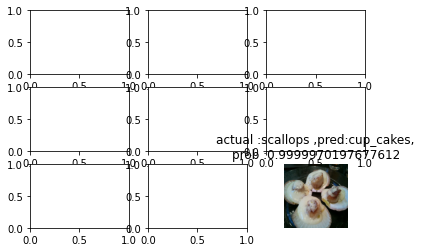

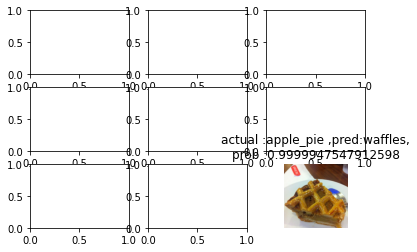

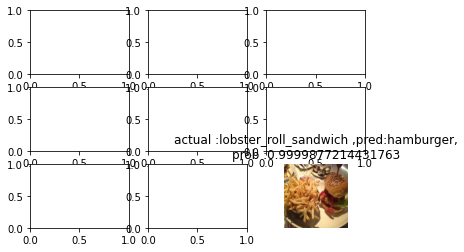

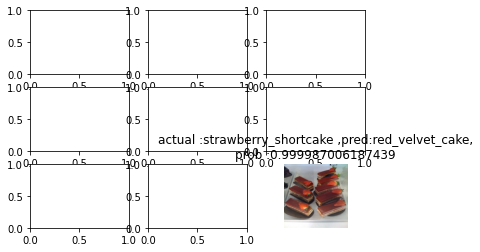

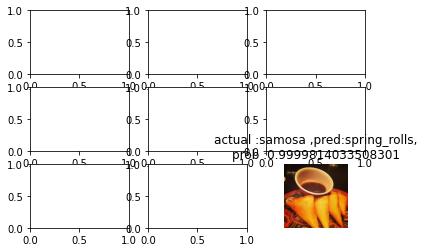

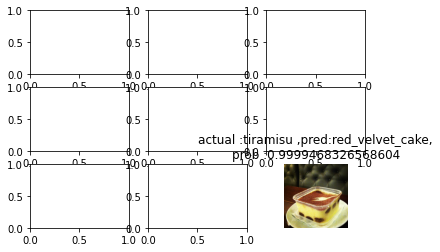

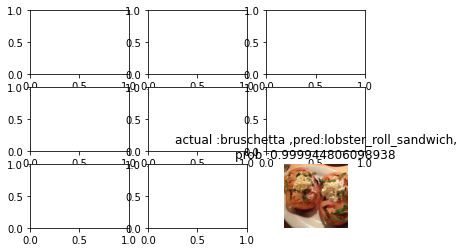

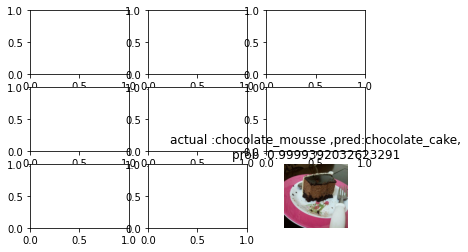

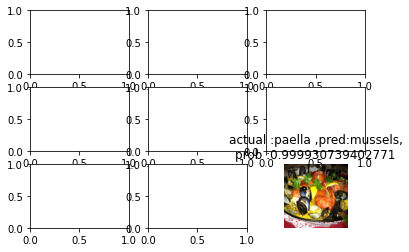

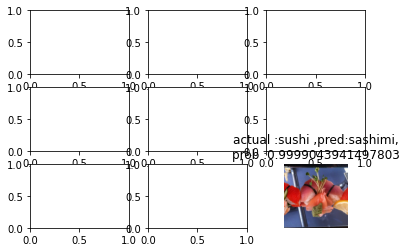

In [80]:
#visualize the data samples with highest wrong predctions
images_to_view=10
start_index=0
plt.figure(figsize=(15,10))

for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplots(3,3)
  img =load_and_prep_image(row[1],scale=False)
  _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_ =row #only intested in few parameters
  plt.imshow(img/255)
  plt.title(f"actual :{y_true_classname} ,pred:{y_pred_classname},\nprob :{pred_prob}")
  plt.axis(False)

##Test Own Images and test Them

In [69]:
#get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-07-24 06:01:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.04s   

2021-07-24 06:01:08 (317 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [71]:
#get the custom food images file path

custom_food_images =["custom_food_images/" +img_path for img_path in os.listdir ("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg']

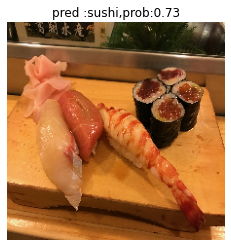

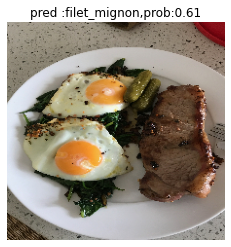

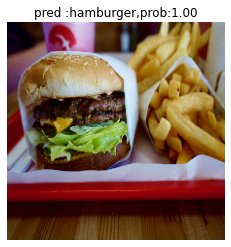

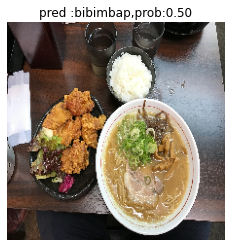

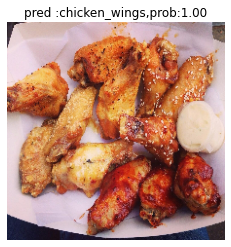

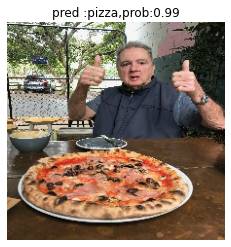

In [73]:
#make and plot cusotm food images
for img in custom_food_images:
  img =load_and_prep_image(img,scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]

  #plot the suitable
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred :{pred_class},prob:{pred_prob.max() :.2f}")
  plt.axis(False)